# Introducrtion to Machine Learning: Assignment #3
## Submission date: 13\03\2024, 23:55.
### Topics:
- PAC, VCdim
- Decision Trees
- Cross validation
- Random forest
- kernel regression

Submitted by:

Or Dinar 207035809

**Assignment Instruction:**

· Submissions in pairs only.

· The code must be reasonably documented

· Try to keep the code as clean, concise, and short as possible

· Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to disciplinary actions.

· You should save a copy of the notebook to your Drive and answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

· If you wish to work in your IDE, make a `.py` copy of the notebook, but as you finish insert the script back to the matching cells of the notebook.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).

## Question 1 - Decision tree

You are requested by the central bank of America to construct a classifier, for detection whether a banknote is real or fake. <br/>
This will be done by decision tree model. <br/>
The dataset consists of 4 features which were obtained from the digitized images of banknotes.<br/>

Note that the features are continuous! Therefore, use only one threshold and split according to it.


import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

load the data, print the first rows

In [2]:
data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/banknote_authentication.csv')
data.head(3)

,var,skew,curt,entropy,class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


Complete this missing implementation of the following functions:
- ```calculate_entropy(self, data)``` – given data, compute the entropy, where the distribution is over its labels (target class).
- ```calculate_information_gain(self, data, feature)``` – given data and specific feature, compute the information gain given by selecting that feature.

Algorithm: The data is continuous, so create 10 thresholds between the min and max values of that feature. For each threshold, split to left tree and right tree and calculate the gain. Choose the threshold which gives the highest gain, along with the gain itself (to later compare between features) <br/>

Tip: To split the tree (represented by data df), use filter_data.
For example, when calculating the gain of 'skew' with threshold 0.5, you can create the left tree by use ```filter_data(data, 'skew', '0.5', left=True)``` to obtain only those samples.

In [3]:
# Define the ID3 decision tree class
class DecisionTree:
	def __init__(self, criterion='entropy', thresholds=10):
		self.tree = {}
		self.criterion = criterion
		self.thresholds = thresholds

	def calculate_entropy(self, data):
		labels = data.iloc[:, -1]
		unique_labels, labels_counts = np.unique(labels, return_counts=True)
		probs = labels_counts/ len(labels)
		entropy =  -np.sum(probs * np.log2(probs))
		return entropy
	
	def calculate_gini(self, data):
		labels = data.iloc[:, -1]
		unique_labels, labels_counts = np.unique(labels, return_counts=True)
		probs = labels_counts/ len(labels)
		gini =  1 - np.sum(probs ** 2)
		return gini
	
	# calculate the information gain for a certain node, using a specific feature
	def calculate_information_gain(self, data, feature):
		total_impurity = eval(f"self.calculate_{self.criterion}(data)")

		# values interval
		values = np.linspace(np.min(data[feature]), np.max(data[feature]), self.thresholds)
		best_treshold = None
		best_gain = 0
		
		# iterate over each interval and decide which one gives us the best information gain for the current node
		for value in values:
			# split the current node's children into 2 sub-trees
			# features that are greater than value (right split) 
			# features that are lower than value (left split)
			left_split = self.filter_data(data, feature, value, left=True)
			right_split = self.filter_data(data, feature, value, left=False)

			# calculate impurity of each sub-tree, and add the weighted sum of them to 'current_entropy'
			left_impurity = eval(f"self.calculate_{self.criterion}(left_split)")
			right_impurity = eval(f"self.calculate_{self.criterion}(right_split)")
			current_impurity = (len(left_split)/len(data)) * left_impurity + (len(right_split)/len(data)) * right_impurity

			# calculate information gain for the current node
			gain = total_impurity - current_impurity
			
			# get the max gain and the coressponding value
			if(gain > best_gain):
				best_gain = gain
				best_treshold = value
		return best_gain, best_treshold

	def filter_data(self, data, feature, value, left=True):
		if left:
			return data[data[feature] <= value].drop(feature, axis=1)
		else:
			return data[data[feature] > value].drop(feature, axis=1)

	def create_tree(self, data, depth=0):
		# Recursive function to create the decision tree
		labels = data.iloc[:, -1]

		# Base case: if all labels are the same, return the label
		if len(np.unique(labels)) == 1:
			return list(labels)[0]

		features = data.columns.tolist()[:-1]
		# Base case: if there are no features left to split on, return the majority label
		if len(features) == 0:
			unique_labels, label_counts = np.unique(labels, return_counts=True)
			majority_label = unique_labels[label_counts.argmax()]
			return majority_label

		selected_feature = None
		best_gain = 0
		best_treshold = None

		for feature in features:
			gain, treshold = self.calculate_information_gain(data, feature)
			if gain >= best_gain:
				selected_feature = feature
				best_treshold = treshold
				best_gain = gain

		# Create the tree node
		tree_node = {}
		tree_node[(selected_feature, f"<={best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=True), depth+1)
		tree_node[(selected_feature, f">{best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=False), depth+1)

		# check if can unite them.
		if not isinstance(tree_node[(selected_feature, f"<={best_treshold}")], dict) and \
				not isinstance(tree_node[(selected_feature, f">{best_treshold}")], dict):
			if tree_node[(selected_feature, f"<={best_treshold}")] == tree_node[(selected_feature, f">{best_treshold}")]:
				return tree_node[(selected_feature, f"<={best_treshold}")]

		return tree_node

	def fit(self, data):
		self.tree = self.create_tree(data)

	def predict(self, X):
		X = [row[1] for row in X.iterrows()]

		# Predict the labels for new data points
		predictions = []

		for row in X:
			current_node = self.tree
			while isinstance(current_node, dict):
				split_condition = next(iter(current_node))
				feature, value = split_condition
				treshold = float(value[2:])
				if row[feature] <= treshold:
					current_node = current_node[feature, f"<={treshold}"]
				else:
					current_node = current_node[feature, f">{treshold}"]
			predictions.append(current_node)

		return predictions

	def _plot(self, tree, indent):
		depth = 1
		for key, value in tree.items():
			if isinstance(value, dict):
				print(" " * indent + str(key) + ":")
				depth = max(depth, 1 + self._plot(value, indent + 2))
			else:
				print(" " * indent + str(key) + ": " + str(value))
		return depth

	def plot(self):
		depth = self._plot(self.tree, 0)
		print(f'depth is {depth}')

You are ready - define DecisionTree, fit it on the entire data and plot the tree. <br/>
The depth of the tree should be 4

In [4]:
tree = DecisionTree()
tree.fit(data)
tree.plot()

('var', '<=0.6617333333333333'):
  ('skew', '<=4.043366666666667'): 1
  ('skew', '>4.043366666666667'):
    ('curt', '<=1.4297444444444443'):
      ('entropy', '<=-3.12498'): 1
      ('entropy', '>-3.12498'): 0
    ('curt', '>1.4297444444444443'): 0
('var', '>0.6617333333333333'):
  ('curt', '<=-2.187766666666667'):
    ('skew', '<=5.5070500000000004'): 1
    ('skew', '>5.5070500000000004'): 0
  ('curt', '>-2.187766666666667'): 0
depth is 4


Now, we will use other method, instead of entropy, $$\text{gini}(A)=1-\sum_{i\in C}p(i)^2$$
We will modify our DecisionTree: <br/>
```
def __init__(self, criterion='entropy'):
        self.tree = {} <br/>
        self.criterion = criterion
```

Modify the rest of the code to support criterion, whether is gini or entropy.


Train both criterions for 10 thresholds, print the train and test accuracy.

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['class'])

for criterion in ["entropy", "gini"]:
	print(f"------------ {criterion} ------------")
	# define a decision tree and fit the training data on it
	tree_train = DecisionTree(criterion)
	tree_train.fit(train)

	# compare true labels with predicted labels
	trainLabels = train.iloc[:, -1]
	trainPreds = tree_train.predict(train)
	acc = np.mean( trainPreds == trainLabels)
	print(f'Training accuracy is {acc}')

	# test the trained decision tree with the test set
	testLabels = test.iloc[:, -1]
	testPreds = tree_train.predict(test)
	acc = np.mean( testPreds == testLabels)
	print(f'Test accuracy is {acc}')
	print()

------------ entropy ------------
Training accuracy is 0.9206927985414768
Test accuracy is 0.9127272727272727

------------ gini ------------
Training accuracy is 0.9161349134001823
Test accuracy is 0.9018181818181819



Train both criterions for 100 thresholds, print the train and test accuracy.<br/> Which criterion is considered better in ML terms? <br/>
<font color='aqua'>The accuracy for train and test are similar, that means the classifier generalizes pretty good. If the definition of generalzation is `TestAcc > TrainAcc` than there isn't a big difference. However, entropy performs a little bit better than gini.</font>

In [6]:
for criterion in ["entropy", "gini"]:
	print(f"------------ {criterion} ------------")
	# define a decision tree and fit the training data on it
	tree_train = DecisionTree(criterion, thresholds=100)
	tree_train.fit(train)

	# compare true labels with predicted labels
	trainLabels = train.iloc[:, -1]
	trainPreds = tree_train.predict(train)
	acc = np.mean( trainPreds == trainLabels)
	print(f'Training accuracy is {acc}')

	# test the trained decision tree with the test set
	testLabels = test.iloc[:, -1]
	testPreds = tree_train.predict(test)
	acc = np.mean( testPreds == testLabels)
	print(f'Test accuracy is {acc}')
	print()

------------ entropy ------------
Training accuracy is 0.9307201458523245
Test accuracy is 0.9090909090909091

------------ gini ------------
Training accuracy is 0.9243391066545124
Test accuracy is 0.8981818181818182



## Question 2 - Random forest

Ensemble learning is a general technique to combat overfitting, by combining the predictions of many varied models into a single prediction based on majority vote or their average.<br/>

You will extend the tree from question 2 into Random Forest

import libraries

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from sklearn.model_selection import KFold

Split into train and test

In [8]:
data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/banknote_authentication.csv')
train, test = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)

Complete the missing implementation of the ```fit``` function. <br/>
Algorithm: Learn n_estimators trees. Each tree draws data, using sample_data and then selects features randomly, by select_features function. Finally, fit each tree to it's data.

In [9]:
# Define the ID3 decision tree class
class RandomForest:
	def __init__(self, n_estimators=3, method='simple', criterion='entropy'):
		self.forest = []
		self.criterion = criterion
		self.n_estimators = n_estimators
		self.method = method
    
    # this method selects a random n feature subset of the data and returns it
	def select_features(self, data):
		np.random.seed(40+len(self.forest))

		if self.method == 'sqrt':
			m = int(np.sqrt(len(data.columns)-1))
		elif self.method == 'log':
			m = int(np.log2(len(data.columns)-1))
		else:
			m = np.random.randint(0, len(data.columns))

        # select random m features for current classifier
		incidies = np.random.choice(np.arange(0, len(data.columns)-1), size=m, replace=False)
		features = list(data.columns[incidies])
		
        # returns the data only with the selected m features, and their class
		return data[features + ['class']]

	# returns row indices of |selected features| to account
	def sample_data(self, data):
		indices = np.random.choice(np.arange(0, len(data)-1), size=len(data)-1)
		return indices

	def fit(self, data):
		self.forest = []
		for _ in range(self.n_estimators):
			samp_data = data.iloc[self.sample_data(data)]
			features = self.select_features(samp_data)

			# define a decision tree to add to the forest
			tree = DecisionTree(criterion=self.criterion, thresholds=100)
			tree.fit(features)
			self.forest.append(tree)


	def _predict(self, X):
		# Predict the labels for new data points
		predictions = []

		preds = [tree.predict(X) for tree in self.forest]
		preds = list(zip(*preds))
		predictions = [Counter(est).most_common(1)[0][0] for est in preds]

		return predictions

	def score(self, X):
		pred = self._predict(X)
		return (pred == X.iloc[:,-1]).sum() / len(X)


Compare Random Forest with 3 trees using entropy vs gini, on both train and test set. Each tree should use 100 thresholds.
<br/> Which criterion is considered better in ML terms? <br/>
<font color='aqua'>Honestly they both generalize almost the same so I I'd pick the one with better accuracy which is Entropy.</font>

In [12]:
dict1 = {'entropy': [], 'gini': []}

criterions = ['entropy', 'gini']
for crt in criterions:
  forest = RandomForest(n_estimators=3, method='simple', criterion=crt)
  forest.fit(train)

  acc = forest.score(train)
  dict1[crt].append(acc)

  acc = forest.score(test)
  dict1[crt].append(acc)

print('using 3 estimators')
df = pd.DataFrame(dict1, columns=criterions, index=['train', 'test'])
print(df)

using 3 estimators
        entropy      gini
train  0.810392  0.792160
test   0.763636  0.745455


You think that Sharon cheated and maybe by using another number of estimators you can get better accuracy. You will use cross validation.<br/>
Complete the missing code in the KFold function.<br/>
Tip: We saw a similar example code in the tutorials.

In [13]:
def KFold2(data, model, cv=5):
  kf = KFold(n_splits=cv)
  scores = []

  for train_index, test_index in kf.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    model.fit(train_data)
    score = model.score(test_data)
    scores.append(score)

  return np.mean(scores)

Prepear graph to compare both criterions along different number of estimators.<br/>
Tip: run it for one iteration first, to ensure your code works

100%|██████████| 17/17 [15:46<00:00, 55.67s/it]


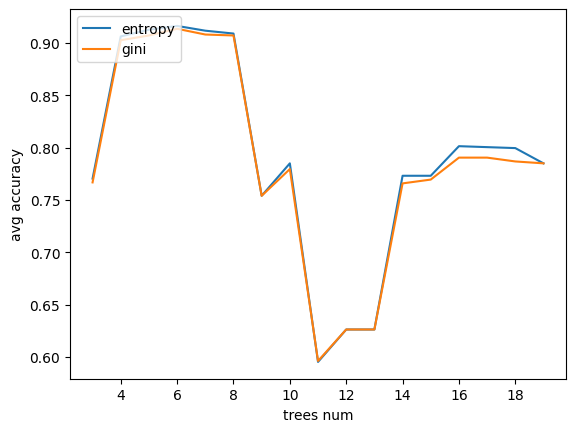

In [14]:
correct_entropy = []
correct_gini = []

# I made the range a variable for ease of use
myRange = range(3,20,1)

for i in tqdm(myRange):
	forest = RandomForest(n_estimators=i, method='simple', criterion='gini')
	correct_gini.append(KFold2(data=train, model=forest, cv=5))
	forest = RandomForest(n_estimators=i, method='simple', criterion='entropy')
	correct_entropy.append(KFold2(data=train, model=forest, cv=5))

plt.plot(myRange, np.array(correct_entropy), label='entropy')
plt.plot(myRange, np.array(correct_gini), label='gini')

plt.legend(loc='upper left')
plt.xlabel('trees num')
plt.ylabel('avg accuracy')
plt.show()

Use the best number of estimators you found, retrain the model and print the accuracies on train and test. <br/>
Now, which model is better generalizer? <br/>
<font color='aqua'>It depends on how I pick the number of estimators, if I picked the number of estimators to be 6 (which is where gini excelled), then gini would be a better generalizer. BUT! in this dataset it seems entropy is a little bit better at generalizing it's predictions towards test sets.</font>

In [15]:
dict1 = {'entropy': [], 'gini': []}

# best_n = int(np.max(correct_entropy))
best_n = 6

criterions = ['entropy', 'gini']
for crt in criterions:
  forest = RandomForest(n_estimators=best_n, method='simple', criterion=crt)
  forest.fit(train)

  acc = forest.score(train)
  dict1[crt].append(acc)

  acc = forest.score(test)
  dict1[crt].append(acc)

print(f'using {best_n} estimators')
df = pd.DataFrame(dict1, columns=criterions, index=['train', 'test'])
print(df)

using 6 estimators
        entropy      gini
train  0.925251  0.927985
test   0.909091  0.916364


Answer the following questions:
- Compared to decision trees, what is the conclusion about the Random Forest model, in terms of generalization, overfitting and correlation?
- In our task, we used only method='simple', but not 'square' nor 'log'. Without running, would they work? Why?<br/>

<font color='aqua'>
<ol>
  <li>Random forest will generalize better, the probability of overfitting is really low since we select random features to account in each tree, and the correlation should be non-existent since in each tree we should use different samples and also different features.</li>
  <li>It should work, the main difference is the amount of features we'll select in each decision tree in the forest.</li>
</ol>
</font>

## Question 3 - Linear kernelization

You are given dataset for regression problem, with one feature (x) and prediction (y) and aim to build the best regressor.

import libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
import requests
from io import BytesIO

load the data

In [17]:
def load_npy_file(url):
    response = requests.get(url)
    if response.status_code == 200:
        npy_data = np.load(BytesIO(response.content), allow_pickle=True).item()
        return npy_data
    else:
        return None

# Load the dictionary
data_dict = load_npy_file('https://sharon.srworkspace.com/ml/datasets/hw3/linreg_data_2d.npy')

# Access the data as needed
x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']

Look at the plot of the training data. <br/>

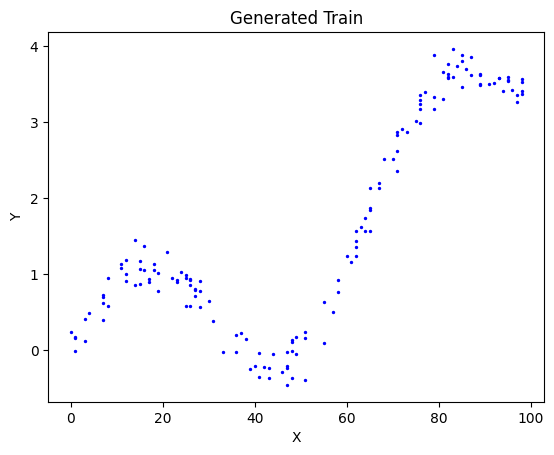

In [18]:
plt.scatter(x_train, y_train, color='blue', s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Train')
plt.show()

You will use kernelized ridge regression (as learned in tutorial 6) and assume b=0. <br/>
Implement the following functions:
-	```kernel(xi, xj, sigma)```: returns the gaussian kernel value $K(x_i,x_j)$.
-	```prepear_kernel_matrix(train)```: using the training, return the Kernel matrix, sized n x n.
-	```get_alphas(kernel, target)```: returns the alphas, as learned.
-	```predict(alphas, train, test)```: predict the regressor for one test sample.

For efficiency, make sure ```kernel```,```predict``` won't contain any loops, and ```prepear_kernel``` will only contain one loop

In [23]:
def kernel(xi, xj, sigma):
  return np.exp(-(np.linalg.norm(xi-xj) ** 2)/ 2 * (sigma ** 2))

def prepear_kernel_matrix(train, sigma):
  K = np.zeros((len(train), len(train)))
  for i in range(len(train)):
    for j in range(len(train)):
      K[i,j] = kernel(train[i], train[j], sigma)
  return K

def get_alphas(kernel, target, lamda=0.01):
  return (np.linalg.inv(kernel + lamda* np.identity(len(target))).dot(target))

def predict(alphas, train, test, sigma):
  pred = 0
  for i, rowTrain in enumerate(train):
    pred += alphas[i] * kernel(train[i], test, sigma)

Use $\sigma=4$ and plot in black the regressor.

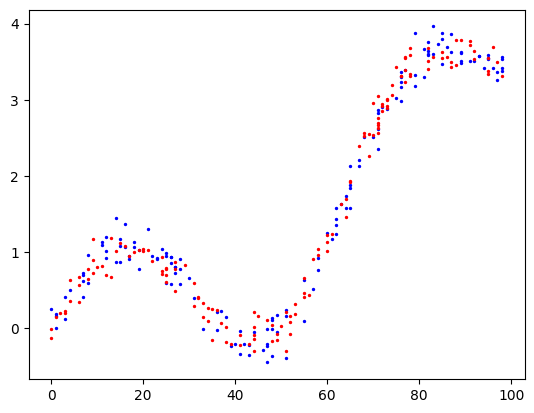

In [24]:
xx = np.arange(0, 100, 0.1).reshape((1000,1))
yy = []
train_kernel = prepear_kernel_matrix(x_train, sigma=4)
alphas = get_alphas(train_kernel, y_train)

for samp in xx:
  yy.append(predict(alphas, x_train, samp, sigma=4))

plt.scatter(x_train, y_train, color='blue', s=2, label='train')
plt.scatter(x_test, y_test, color='red', s=2, label='test')
plt.plot(xx, yy, color='black')
plt.show()

Print MSE of train and test.

In [25]:
mse = 0
for idx, samp in enumerate(x_train):
  mse += (predict(alphas, x_train, samp, sigma=4) - y_train[idx]) ** 2
mse = mse / len(x_train)
print(f'train mse is {mse}')

mse = 0
for idx, samp in enumerate(x_test):
  mse += (predict(alphas, x_train, samp, sigma=4) - y_test[idx]) ** 2
mse = mse / len(x_test)
print(f'test mse is {mse}')

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

Create validation set with 20 samples, using train_test_split and random search to tune better $λ,\sigma$. <br/>

In [ ]:
# Implement here

Train the model again on all the training, on the best tuned hyperparamters. Don't forget to re-generate the alphas<br/>
Print the new train and test MSE.

In [ ]:
# Implement here

Plot new vs old regressor. Is the result better? (answer for yorselves)

In [ ]:
xx = np.arange(0, 100, 0.1).reshape((1000,1))
yy2 = []

for samp in xx:
  yy2.append(predict(alphas, x_train, samp, sigma=best_sigma))

plt.scatter(x_train, y_train, color='blue', s=2, label='train')
plt.scatter(x_test, y_test, color='red', s=2, label='test')
plt.plot(xx, yy, color='black', label='origin plot')
plt.plot(xx, yy2, color='green', label='tuned plot')
plt.legend()
plt.show()

## Question 4 - PAC
See attached pdf in moodle assignment!

## Question 5 - 3 points bonus

Recall the data you've worked with in hw1. Now we are going to look at it again but apply ridge regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array([[0.4, 3.4], [0.95, 5.8], [0.16, 2.9], [0.7, 3.6], [0.59, 3.27], [0.11, 1.89], [0.05, 4.5], [0.6, 5.0]])

solve and plot the regular line. Bad line, bad!

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(data[:,:1], data[:,1])

print("MSE IS ", reg.score(data[:,:1], data[:,1]))

x = np.arange(-0.01, 1, 0.01)
y = reg.coef_ * x + reg.intercept_
plt.plot(x,y)

plt.scatter(data[:,0], data[:,1], color='blue', label='Data')
plt.show()

Now, do the same with ridge. Better?

In [ ]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1).fit(data[:,:1], data[:,1])

print("MSE IS ", reg.score(data[:,:1], data[:,1]))

x = np.arange(-0.01, 1, 0.01)
y = reg.coef_ * x + reg.intercept_
plt.plot(x,y)

plt.scatter(data[:,0], data[:,1], color='blue', label='Data')
plt.show()

Robust linear regression!

In [ ]:
from sklearn.linear_model import RANSACRegressor

reg = RANSACRegressor(random_state=0).fit(data[:,:1], data[:,1])

print("MSE IS ", reg.score(data[:,:1], data[:,1]))

x = np.arange(-0.01, 1, 0.01)
y = reg.predict(x[:,np.newaxis])
plt.plot(x,y)

plt.scatter(data[:,0], data[:,1], color='blue', label='Data')
plt.show()

Actually, robust linear regression has the following objective:
$$ w,b=\text{arg}\min_{w,b} ||\bar{X}w-b||_2^2+x^\top P x$$
$U$ is random noise, $\mathbb{E}[U]=0$ and $P=U^\top U$. Moreover, $\bar{X}=X+U$.
where $X$ is our original data. We already saw that regular linear regression works under the assumption of gaussian noise, but what happens when $P=\delta I$? <br/>
<font color='red'>Write here your answer and explain it</font>